### Load necessary modules

In [1]:
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import load_model
%matplotlib inline

C:\Users\georg\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_detection_model(model_path):
    detection_model = cv2.CascadeClassifier(model_path)
    return detection_model

In [3]:
def detect_faces(detection_model, gray_image_array):
    return detection_model.detectMultiScale(gray_image_array, 1.3, 5)

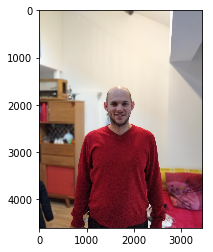

In [4]:
image = mpimg.imread('../data/image/me.jpg')
plt.imshow(image)
plt.show()

In [5]:
# load parameters for face detection
detection_model_path = '../data/image/face.xml'
 
# read the image
image = cv2.imread('../data/image/me.jpg')

#convert from rgb to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect the face
face_detection = load_detection_model(detection_model_path)
face = detect_faces(face_detection, gray_image)[0]

# Coordinates of the face in the image
x1 = face[0]
y1 = face[1]
w = face[2]
h = face[3]

In [6]:
# crop the face
crop_img = gray_image[y1:(y1+h),x1:(x1+w)]

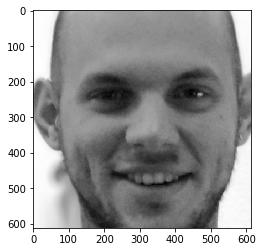

In [7]:
plt.imshow(crop_img, cmap='gray')

In [8]:
# width, height of the image
crop_img.shape

(612, 612)

In [9]:
resized_image = cv2.resize(crop_img, (48,48))
resized_image = resized_image / 255.0
# reshape to 48,48,1
resized_image = np.reshape(resized_image, newshape=(1,48,48,1))

In [10]:
# load the best model
model = load_model('../logs/wideResNet/model.hdf5')

In [11]:
# Get the probability for every emotion 
probabilities = model.predict(resized_image)[0].tolist()
print(probabilities)

[0.0008011393365450203, 0.9991466999053955, 1.8923572497442365e-05, 3.2763221042841906e-06, 5.449328455142677e-06, 1.7943562852451578e-05, 9.198478423400047e-09, 6.465729256888153e-06]


In [12]:
# Emotion with its corresponding index 
emotions = [0,1,2,3,4,5,6,7]
emotions_names = ['neutral', 'happiness', 'surprise', 'sad', 'anger', 'disgust', 'fear', 'contempt']

In [13]:
# Sort the emotions starting from the most probable
probabilities1, emotions = zip(*sorted(zip(probabilities, emotions), reverse=True))
probabilities, emotions_names = zip(*sorted(zip(probabilities, emotions_names), reverse=True))

In [14]:
print('emotions indices', emotions)
print('emotions', emotions_names)

emotions indices (1, 0, 2, 5, 7, 4, 3, 6)
emotions ('happiness', 'neutral', 'surprise', 'disgust', 'contempt', 'anger', 'sad', 'fear')


### Use Action Units

In [15]:
# Top-2 emotions (Happiness, Neutral) -> 01
# Take only the action units that describe those 2 emotions
action_units01 =  [' AU6_c', ' AU12_c', ' AU25_c']

#Top-3 emotions (Happiness, Neutral, Surprise) -> 012
# Take only the action units that describe those 3 emotions 
actions_units012 = [' AU01_c', ' AU02_c', ' AU05_c', ' AU06_c', ' AU12_c', ' AU25_c']

In [16]:
# Read Action Units
data = pd.read_csv('../data/image/me.csv')

In [17]:
data

,face,confidence,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,gaze_angle_x,gaze_angle_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,1,0.983,0.10161,0.260897,-0.960004,-0.089386,0.287131,-0.953712,0.006,0.279,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


### Load the SVM classifier for the top-2 emotions (Neutral, Happiness)

In [18]:
top2_model = pickle.load(open('../Action_units_final/top2_pre/svm01.sav', 'rb'))

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\georg\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [19]:
# Read only the action units that corresponds to top-2 emotions
top_2 = data[[' AU06_c', ' AU12_c', ' AU25_c']]
top_2

,AU06_c,AU12_c,AU25_c
0,1.0,1.0,1.0


In [20]:
top_2 = np.array(top_2)

In [21]:
# Again the predicted emotion is 1 -> Happiness
top2_model.predict(top_2)

array([1], dtype=int64)

### Load the SVM classifier for the top-3 emotions (Neutral, Happiness, Surprise)

In [22]:
top3_model = pickle.load(open('../Action_units_final/top3_pre/svm012.sav', 'rb'))

C:\Users\georg\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator SVC from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\georg\Anaconda3\lib\site-packages\sklearn\base.py:311: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.19.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
# Read only the action units that corresponds to top-3 emotions
top_3 = data[[' AU01_c', ' AU02_c', ' AU05_c', ' AU06_c', ' AU12_c', ' AU25_c']]
top_3

,AU01_c,AU02_c,AU05_c,AU06_c,AU12_c,AU25_c
0,0.0,0.0,1.0,1.0,1.0,1.0


In [24]:
top_3 = np.array(top_3)

In [25]:
# Again the predicted emotion is 1 -> Happiness
top3_model.predict(top_3)

array([1], dtype=int64)